# MNIST handwritten digit classification

### Load modules

In [1]:
import tensorflow as tf
import numpy as np
import sys
import os

from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.contrib.tensorboard.plugins import projector
from matplotlib import pyplot as plt

LOGDIR = "./tensorflow_summaries"
DATADIR = "./MNIST_data"

plt.style.use('ggplot')
%matplotlib inline

### Load data

In [2]:
mnist = input_data.read_data_sets(DATADIR, one_hot=True)
x_train = mnist.train.images
y_train = mnist.train.labels
x_test = mnist.test.images
y_test = mnist.test.labels

Extracting ./MNIST_data/train-images-idx3-ubyte.gz
Extracting ./MNIST_data/train-labels-idx1-ubyte.gz
Extracting ./MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./MNIST_data/t10k-labels-idx1-ubyte.gz


### Plot digit

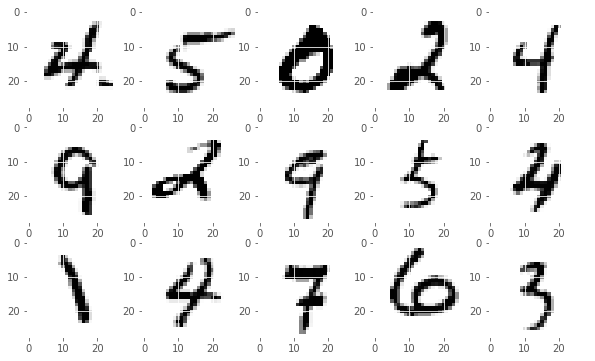

In [3]:
n_train = np.shape(x_train)[0]
rand_digit = lambda: np.reshape(x_train[np.random.randint(n_train)], (28, 28))

fig, ax = plt.subplots(figsize=(10, 6))
for i in range(1, 5*3+1):
    plt.subplot(3, 5, i)
    plt.imshow(rand_digit(), cmap='Greys')

### TensorFlow and TensorBoard helper functions

In [4]:
def variable_summaries(var, scope='summaries'):
    with tf.name_scope(scope):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)
        
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial, name='W')

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial, name='b')

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], 
                        padding='SAME', name='convolution')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], 
                          padding='SAME', name='max_pool')

def apply_conv(x, shape, summarize=True):
    W_conv = weight_variable(shape)
    b_conv = bias_variable([shape[-1]])
    h_conv = tf.nn.relu(conv2d(x, W_conv) + b_conv)
    h_pool = max_pool_2x2(h_conv)
    if summarize:
        variable_summaries(W_conv, "weights")
        variable_summaries(b_conv, "biases")
    return h_pool

### One CNN to rule them all

In [5]:
# reset graph (important for batch normalization and summary)
tf.reset_default_graph()

# placeholder
x_input = tf.placeholder(tf.float32, [None, 784])
y_input = tf.placeholder(tf.float32, [None, 10])
keep_prob = tf.placeholder(tf.float32)

with tf.device("/cpu:0"):
    
    with tf.name_scope("reshape"):
        x_image = tf.reshape(x_input, [-1, 28, 28, 1])
        tf.summary.image('input', x_image, 3)
        
    with tf.name_scope("conv1"):
        h1 = apply_conv(x_image, [5, 5, 1, 32])
        
    with tf.name_scope("conv2"):
        h2 = apply_conv(h1, [5, 5, 32, 64])
            
    with tf.name_scope("fully_connected"):
        W = weight_variable([7*7*64, 1024])
        b = bias_variable([1024])
        h_flat = tf.reshape(h2, [-1, 7*7*64])
        h_relu = tf.nn.relu(tf.matmul(h_flat, W) + b)
        
    with tf.name_scope("embedding"):
        embedding_input = h_relu
        embedding_size = 1024
        
    with tf.name_scope("dropout"):
        h_drop = tf.nn.dropout(h_relu, keep_prob) 
        
    with tf.name_scope("readout"):
        W2 = weight_variable([1024, 10])
        b2 = bias_variable([10])
        y_conv = tf.matmul(h_drop, W2) + b2
        
    with tf.name_scope("xentropy"):
        xent = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(
                labels=y_input, 
                logits=y_conv))
        tf.summary.scalar('cross_entropy', xent)
        
    with tf.name_scope("optimization"):
        train_step = tf.train.AdamOptimizer().minimize(xent)
        
    with tf.name_scope("accuracy"):
        correct = tf.equal(tf.argmax(y_conv, axis=1), tf.argmax(y_input, axis=1)) 
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
        tf.summary.scalar('accuracy', accuracy)
        
    # embedding
    embedding = tf.Variable(tf.zeros([1024, embedding_size]), name="test_embedding")
    assignment = embedding.assign(embedding_input)
    saver = tf.train.Saver()
    
    # summmary
    merged = tf.summary.merge_all()
    
    # init. of tensors
    init = tf.global_variables_initializer()

### Test graph architecture

In [6]:
%%time
with tf.Session() as sess:
    sess.run(init)
    xs, ys = mnist.test.images, mnist.test.labels
    feed_dict = {x_input: xs, y_input: ys, keep_prob: 1}
    __ = sess.run(accuracy, feed_dict=feed_dict)
    print(np.shape(__))

()
CPU times: user 19.7 s, sys: 1.35 s, total: 21.1 s
Wall time: 1.47 s


### Clean summaries folder

In [7]:
def clean_folder(path):
    for file in os.listdir(path):
        filepath = os.path.join(path, file)
        if os.path.isfile(filepath):
            os.remove(filepath)
            
clean_folder(os.path.join(LOGDIR, "test"))
clean_folder(os.path.join(LOGDIR, "train"))
clean_folder(os.path.join(LOGDIR, "checkpoints"))

### Train model 

In [8]:
%%time

# feed dict helper
def feed_dict(train=True, p=1):
    batch_size = 50
    if train:
        xs, ys = mnist.train.next_batch(batch_size)
        k = p
    else:
        xs, ys = mnist.test.images, mnist.test.labels
        k = 1
    return {x_input: xs, y_input: ys, keep_prob: k}

# dropout: keep probability
p = 0.5

# using graph for training
with tf.Session() as sess:
    sess.run(init)
    train_writer = tf.summary.FileWriter(os.path.join(LOGDIR, "train"), sess.graph)
    test_writer = tf.summary.FileWriter(os.path.join(LOGDIR, "test"), sess.graph)
    emb_writer = tf.summary.FileWriter(os.path.join(LOGDIR, "checkpoints"), sess.graph)
    
    # embedding for tensorboard
    config = projector.ProjectorConfig()
    emb_config = config.embeddings.add()
    emb_config.tensor_name = embedding.name
    emb_config.sprite.image_path = os.path.join(DATADIR, "sprite_1024.png")
    emb_config.metadata_path = os.path.join(DATADIR, "labels_1024.tsv")
    emb_config.sprite.single_image_dim.extend([28, 28])
    projector.visualize_embeddings(emb_writer, config)
    
    # loss
    losses = list()
    for i in range(1000):
        if i % 100 == 0:
            summary, acc, l = sess.run([merged, accuracy, xent], feed_dict=feed_dict(False))
            test_writer.add_summary(summary, i)
            print('epoch %4d:   test acc: %2.3f   test loss: %2.3f' % (i, acc, l))
        if i % 500 == 0:
            D = {
                x_input: mnist.test.images[:1024], 
                y_input: mnist.test.labels[:1024],
                keep_prob: 1}
            sess.run(assignment, feed_dict=D)
            saver.save(sess, os.path.join(LOGDIR, "checkpoints/model.ckpt"), i)
        summary, __, l= sess.run([merged, train_step, xent], feed_dict=feed_dict(True, p))
        losses.append(l) 
        train_writer.add_summary(summary, i)

epoch    0:   test acc: 0.098   test loss: 18.886
epoch  100:   test acc: 0.933   test loss: 0.222
epoch  200:   test acc: 0.959   test loss: 0.132
epoch  300:   test acc: 0.962   test loss: 0.118
epoch  400:   test acc: 0.967   test loss: 0.096
epoch  500:   test acc: 0.974   test loss: 0.080
epoch  600:   test acc: 0.979   test loss: 0.062
epoch  700:   test acc: 0.981   test loss: 0.063
epoch  800:   test acc: 0.980   test loss: 0.061
epoch  900:   test acc: 0.982   test loss: 0.056
CPU times: user 9min 44s, sys: 1min 56s, total: 11min 40s
Wall time: 1min 6s


#### Plot training loss

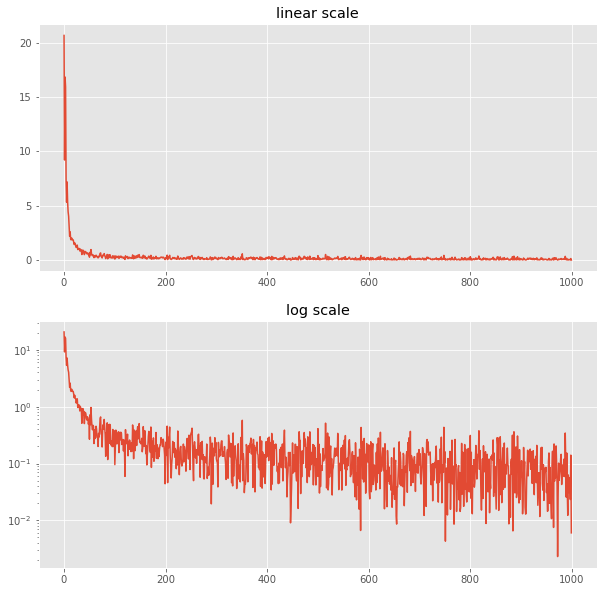

In [9]:
fig, ax = plt.subplots(figsize=(10, 10))

plt.subplot(211)
plt.title('linear scale')
plt.plot(losses)

plt.subplot(212)
plt.title('log scale')
plt.yscale('log')
plt.plot(losses)